In [1691]:
import sys
import importlib
import numpy as np
import matplotlib.pyplot as plt


In [1692]:
sys.path.append('..')  # Go up one directory to where utils.py is located
import utils  # Ensure you import the module itself, not specific items
importlib.reload(utils)  # Reload the module to apply updates
from utils import * 

Consider the simple harmonic oscillator $x:\mathbb{R}^+ \to \mathbb{R}$ given by:
$$ \begin{cases}
\frac{d^2x}{dt^2} &= -\omega^2 x \\
x(0) &= q_0 \\
\frac{dx}{dt}|_{t=0}& = p_0.
\end{cases},
$$
which can be reformulated as a system of differential equations
$$ 
\begin{cases}
\frac{dx}{dt} = y \\
\frac{dy}{dt} = -\omega^2 x  \\
x(0) = q_0 \\
y(0) = p_0,
\end{cases}
$$
where we defined $y:= \frac{dx}{dt}$. Our goal is to implement a simple DeepONet to approximate a solution for this BVP.

The analytical solution of the BVP is 
$$
\begin{cases}
x(t) = q_0 \cos(\omega t) + \frac{p_0}{\omega}\sin(\omega t)\\
y(t) = p_0 \cos(\omega t) - q_0 \omega \sin(\omega t).
\end{cases}
$$

In [1693]:
# Get analytical solution of the BVP for given q0, p0 and t
def analytic_solution(bv, t, w=1):
    q0 = bv[:,None,0] 
    p0 = bv[:,None,1] 
    x = torch.tensor(q0 @ np.cos(w * t).T + (p0 @ np.sin(w * t).T) / w)
    y = torch.tensor(p0 @ np.cos(w * t).T - (q0 @ np.sin(w * t).T) * w)
    return torch.stack((x, y), dim=2)

In [1694]:
T = 20
bv = np.random.uniform(low=-1, high=1, size=(150, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=T, size=(100, 1)).astype(np.float32)
y_train = analytic_solution(bv, t)
X_train = (bv, t)


In [1695]:
bv = np.random.uniform(low=-1, high=1, size=(150, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=T, size=(100, 1)).astype(np.float32)
y_test = analytic_solution(bv, t)
X_test = (bv, t)

In [1696]:
net = DeepONet([2, 128, 128, 128, 128], [1, 128, 128, 128, 128], dim_out=2, activation='tanh')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
model = Model(X_train, y_train, X_test, y_test, net, optimizer)
model.train(iterations=10000)

Step 	 Train loss 	 Test loss
1000 	 [6.21e-02] 	 [5.37e-02]
2000 	 [4.42e-04] 	 [3.90e-04]
3000 	 [6.03e-03] 	 [6.33e-03]
4000 	 [6.98e-04] 	 [8.05e-04]
5000 	 [5.96e-04] 	 [5.55e-04]
6000 	 [3.59e-04] 	 [3.76e-04]
7000 	 [2.46e-04] 	 [3.12e-04]
8000 	 [1.23e-03] 	 [1.15e-03]
9000 	 [2.65e-04] 	 [2.75e-04]
10000 	 [2.39e-04] 	 [2.97e-04]


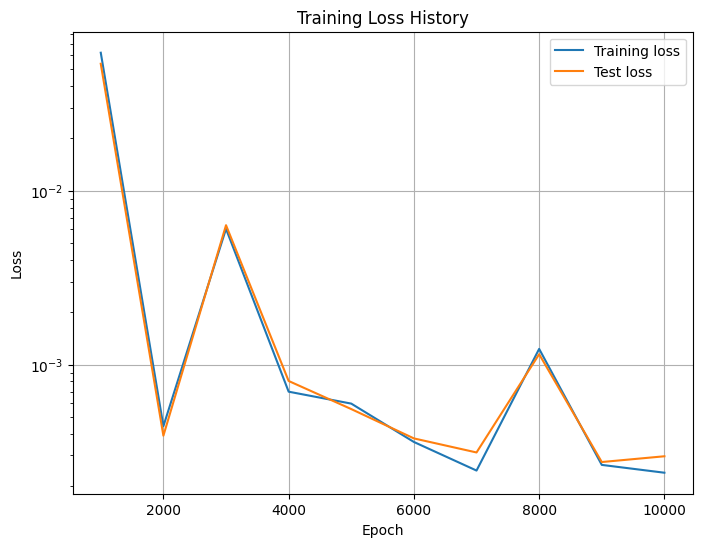

In [1697]:
model.plot_losshistory()

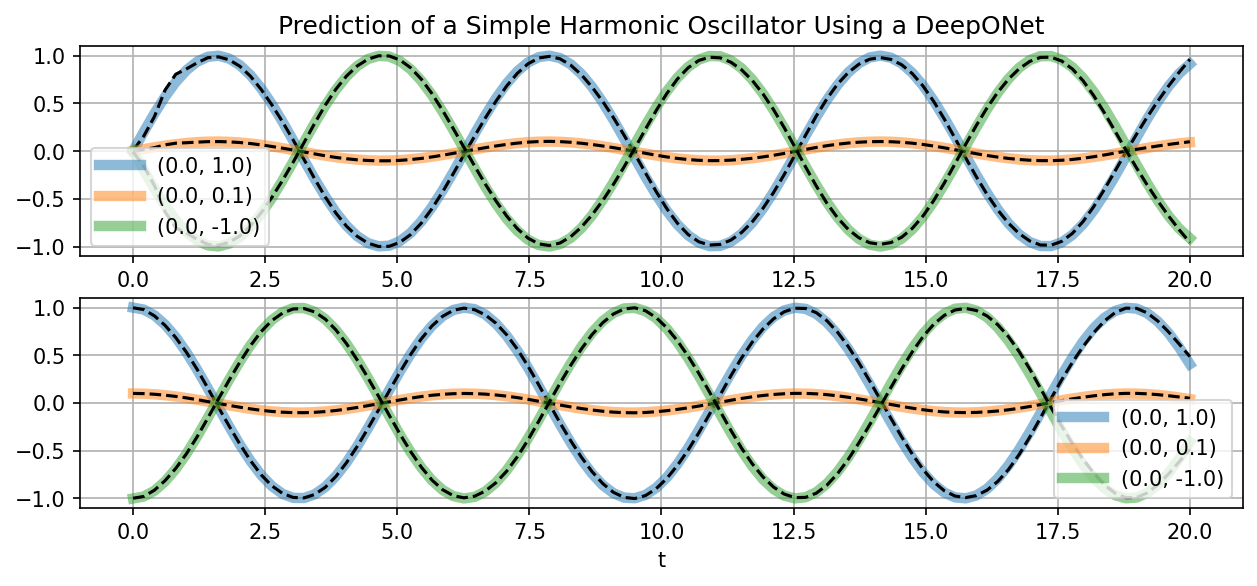

In [1698]:
# Plot model prediction for one omega

# Get model prediction

t = np.linspace(0, T, 100).reshape(-1, 1)
bv = np.array([[0, 1], [0, 0.1], [0,-1]]).astype(np.float32)

ground_truth = analytic_solution(bv, t)

pred = model.predict(bv, t)


# Plot prediction vs. solution
fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=150)

axes[0].set_title('Prediction of a Simple Harmonic Oscillator Using a DeepONet')

for k, ax in enumerate(axes.flat):
    for l in range(pred.shape[0]):
        label = '({:.1f}, {:.1f})'.format(bv[l,0], bv[l,1])
        ax.plot(t.flatten(), ground_truth[l,:,k], label=label, alpha=0.5, linewidth=5)
        ax.plot(t.flatten(), pred[l,:,k].tolist(), '--', c='k')

    ax.legend()
    ax.grid(True)
ax.set_xlabel("t")
plt.show()